In [1]:
#imports
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt


In [2]:
#data imports
regions = pd.read_csv(r'risk_data.csv', sep=";", usecols=[0])
risk_data = pd.read_csv(r'risk_data.csv', sep=";", index_col=0)
asset_values = pd.read_csv(r'asset_values.csv', sep = ";", index_col=0)
influences = pd.read_csv(r'influences.csv', sep=";", index_col = 0)
base_data = pd.read_csv(r'base_data.csv', sep=";", index_col=0)

In [3]:
### calculating base parameters
agg_risk = risk_data.sum(axis=1)

#risk per capita
rpk = agg_risk/base_data["pop"]
# yearly wage per capity
yearly_wage = base_data["sim_wage"]*52
# total population
total_pop = sum(base_data["pop"])
#gdp per capita = productivity
productivity = base_data["gdp"]/base_data["pop"]

In [4]:
### Function to calculate effect of transfer schedule

def pop_dens_func (population):
    return population/base_data["area"]

def wage_func(population_density):
    return (0.0359 * population_density + 598.74) * 52

def risk_pc(population):
    return agg_risk/population

def v_func(wages, transfers, risk_p_capita):
    return base_data["b_i"] * (wages + transfers) / risk_p_capita

def Pi_func(v):
    return v/sum(v)

def H_func(pi):
    return pi * total_pop

def A_func(H):
    return H * productivity
    '''
    A = []
    for i in range(len(agg_risk)):
        A.append(math.pow(H[i], (base_data["prod"][i]/100)))
        
    return A'''

def welfare_func(A):
    return sum(A) - sum(base_data["pop"] * productivity)

# For sanity checks in this cell
pop_dens_0 = pop_dens_func(base_data["pop"])
wage_0 = wage_func(pop_dens_0)
risk_0 = risk_pc(base_data["pop"])
v0 = v_func(wage_0,0,risk_0)
pi_0 = Pi_func(v0)
h_0 = H_func (pi_0)
a_0 = A_func(h_0)
welf_0 = welfare_func(a_0)


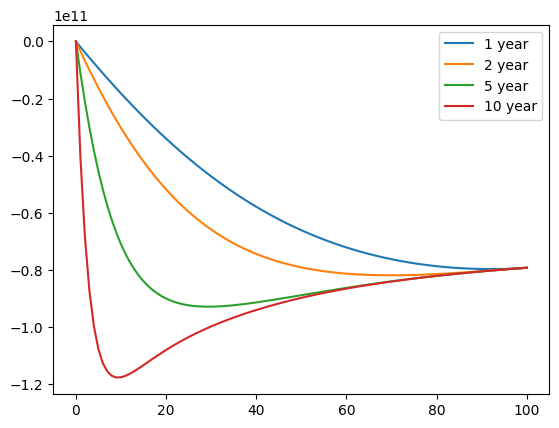

In [5]:
### transfer function 1: collect taxes based on income and distribute according to risk


def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0])*risk_list[0]/sum(risk_list[0]) - taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i])*risk_list[i]/sum(risk_list[i]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1 = []
welfare2 = []
welfare5 = []
welfare10 = []

for i in range(101):
    percentage.append(i)
    welfare1.append(transfer_calculator(1,i/100)[1])
    welfare2.append(transfer_calculator(2,i/100)[2])
    welfare5.append(transfer_calculator(5,i/100)[5])
    welfare10.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1, label = "1 year")
plt.plot(percentage, welfare2, label = "2 year")
plt.plot(percentage, welfare5, label = "5 year")
plt.plot(percentage, welfare10, label = "10 year")
plt.legend(loc="upper right")
#plt.ylim([0,2.5e12])
plt.show()

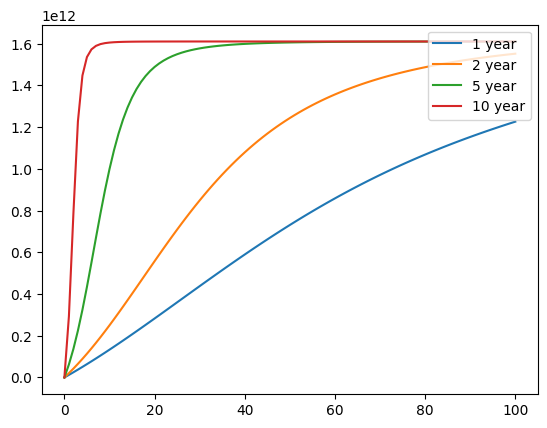

In [6]:
### transfer paymenet method 2: collecting a tax but transferring according to risk and population density

#normalizing risk and population density
def normalizer(population):
    rpk = agg_risk/population
    rpk_norm = rpk/sum(rpk)
    pop_density = population/base_data["area"]
    pop_density_norm = pop_density/sum(pop_density)
    
    return (rpk_norm+pop_density_norm)/2

#transfer function

def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0]) * normalizer(base_data["pop"])- taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i]) * normalizer(h_list[i-1])- taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1t2 = []
welfare2t2 = []
welfare5t2 = []
welfare10t2 = []

for i in range(101):
    percentage.append(i)
    welfare1t2.append(transfer_calculator(1,i/100)[1])
    welfare2t2.append(transfer_calculator(2,i/100)[2])
    welfare5t2.append(transfer_calculator(5,i/100)[5])
    welfare10t2.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1t2, label = "1 year")
plt.plot(percentage, welfare2t2, label = "2 year")
plt.plot(percentage, welfare5t2, label = "5 year")
plt.plot(percentage, welfare10t2, label = "10 year")
plt.legend(loc="upper right")
plt.show()

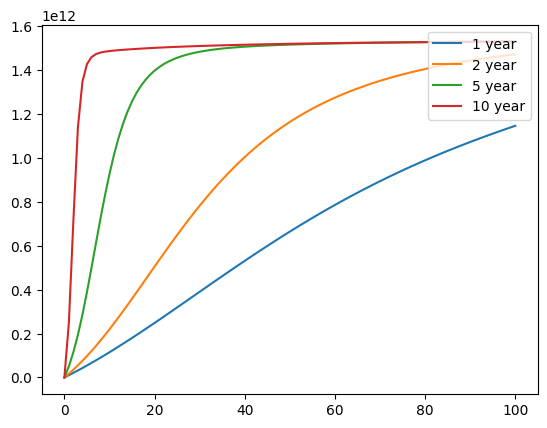

In [7]:
percentage
totwel1 = [welfare1[i] + welfare1t2[i] for i in range(len(welfare1))]
totwel2 = [welfare2[i] + welfare2t2[i] for i in range(len(welfare2))]
totwel5 = [welfare5[i] + welfare5t2[i] for i in range(len(welfare5))]
totwel10 = [welfare10[i] + welfare10t2[i] for i in range(len(welfare10))]

plt.plot(percentage, totwel1, label = "1 year")
plt.plot(percentage, totwel2, label = "2 year")
plt.plot(percentage, totwel5, label = "5 year")
plt.plot(percentage, totwel10, label = "10 year")
plt.legend(loc="upper right")
#plt.ylim([0,2.5e12])
plt.show()

In [21]:
####NEU
# 
# 
# ## Function to calculate effect of transfer schedule

def pop_dens_func (population):
    return population/base_data["area"]

def wage_func(population_density):
    return (0.0359 * population_density + 598.74) * 52

def risk_pc(population):
    return agg_risk/population

def v_func(wages, transfers, risk_p_capita, population_density):
    return base_data["b_i"] * (wages + transfers - (0.0014 * population_density + 7.0373) * wages / 20) / risk_p_capita
    # Here, i devided the housing prices by 20 as it is a usual time to recoup investment in rentals or loan time for homeowners

def Pi_func(v):
    return v/sum(v)

def H_func(pi):
    return pi * total_pop

def A_func(H):
    return H * productivity
    '''
    A = []
    for i in range(len(agg_risk)):
        A.append(math.pow(H[i], (base_data["prod"][i]/100)))
        
    return A'''

def welfare_func(A):
    return sum(A) - sum(base_data["pop"] * productivity)

# For sanity checks in this cell
pop_dens_0 = pop_dens_func(base_data["pop"])
wage_0 = wage_func(pop_dens_0)
risk_0 = risk_pc(base_data["pop"])
v0 = v_func(wage_0,0,risk_0,pop_dens_0)
pi_0 = Pi_func(v0)
h_0 = H_func (pi_0)
a_0 = A_func(h_0)
welf_0 = welfare_func(a_0)


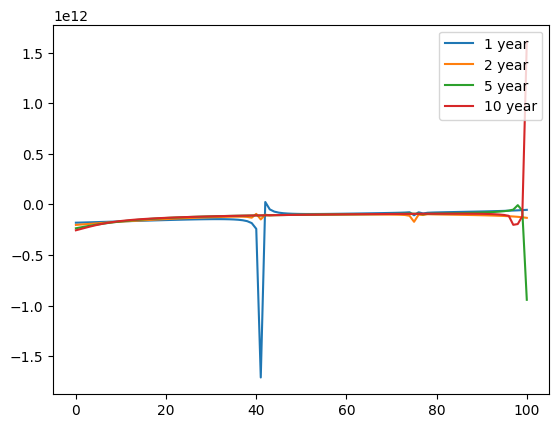

In [22]:
### NEW first schedule

### transfer function 1: collect taxes based on income and distribute according to risk


def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0])*risk_list[0]/sum(risk_list[0]) - taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0, pop_dens_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i])*risk_list[i]/sum(risk_list[i]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i],pop_dens_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1 = []
welfare2 = []
welfare5 = []
welfare10 = []

for i in range(101):
    percentage.append(i)
    welfare1.append(transfer_calculator(1,i/100)[1])
    welfare2.append(transfer_calculator(2,i/100)[2])
    welfare5.append(transfer_calculator(5,i/100)[5])
    welfare10.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1, label = "1 year")
plt.plot(percentage, welfare2, label = "2 year")
plt.plot(percentage, welfare5, label = "5 year")
plt.plot(percentage, welfare10, label = "10 year")
plt.legend(loc="upper right")
#plt.ylim([0,2.5e12])
plt.show()

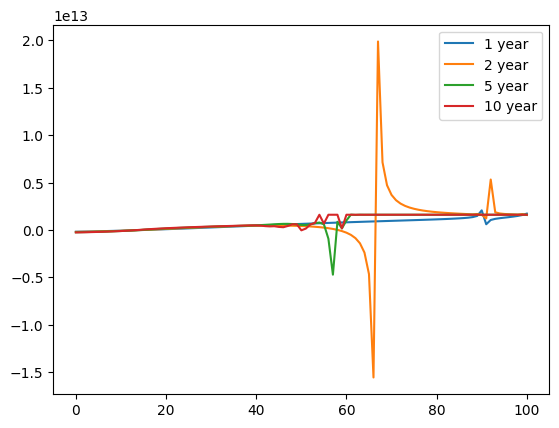

In [23]:
### NEU second schedule

### transfer paymenet method 2: collecting a tax but transferring according to risk and population density

#normalizing risk and population density
def normalizer(population):
    rpk = agg_risk/population
    rpk_norm = rpk/sum(rpk)
    pop_density = population/base_data["area"]
    pop_density_norm = pop_density/sum(pop_density)
    
    return (rpk_norm+pop_density_norm)/2

#transfer function

def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0]) * normalizer(base_data["pop"])- taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0, pop_dens_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i]) * normalizer(h_list[i-1]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i],pop_dens_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1t2 = []
welfare2t2 = []
welfare5t2 = []
welfare10t2 = []

for i in range(101):
    percentage.append(i)
    welfare1t2.append(transfer_calculator(1,i/100)[1])
    welfare2t2.append(transfer_calculator(2,i/100)[2])
    welfare5t2.append(transfer_calculator(5,i/100)[5])
    welfare10t2.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1t2, label = "1 year")
plt.plot(percentage, welfare2t2, label = "2 year")
plt.plot(percentage, welfare5t2, label = "5 year")
plt.plot(percentage, welfare10t2, label = "10 year")
plt.legend(loc="upper right")
plt.show()

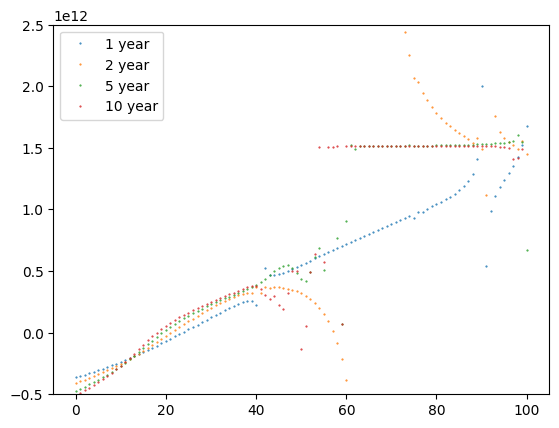

In [40]:
### NEW TOTAL

percentage
totwel1 = [welfare1[i] + welfare1t2[i] for i in range(len(welfare1))]
totwel2 = [welfare2[i] + welfare2t2[i] for i in range(len(welfare2))]
totwel5 = [welfare5[i] + welfare5t2[i] for i in range(len(welfare5))]
totwel10 = [welfare10[i] + welfare10t2[i] for i in range(len(welfare10))]

plt.plot(percentage, totwel1,'o', label = "1 year", markersize = 0.5)
plt.plot(percentage, totwel2, 'o', label = "2 year", markersize = 0.5)
plt.plot(percentage, totwel5, 'o', label = "5 year", markersize = 0.5)
plt.plot(percentage, totwel10, 'o', label = "10 year", markersize = 0.5)
plt.legend(loc="upper left")9o9
plt.ylim([-0.5e12,2.5e12])
plt.show()